# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torchtext
from torchtext.data.utils import get_tokenizer
import seaborn as sns
sns.set(palette="Set2")
sns.set_style("whitegrid")
import nltk
nltk.download("stopwords")
import os

device = "cuda"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

/home/akruglov/.pyenv/versions/3.8.18/envs/python3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akruglov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск

In [3]:
# from google.colab import drive  # в итоге запускал в другом месте
# drive.mount('/content/drive/')

Скачаем данные для обучения и тестирования:

In [4]:
# dataset = pd.read_csv('/content/drive/MyDrive/salary_dataset.csv')
dataset = pd.read_csv('salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [5]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [6]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [7]:
counter = Counter()
for text in tqdm(dataset["FullDescription"]):  # посчитаем количество вхождений каждого токена
    counter.update(token for token in tokenizer(text) if token not in stop_words and token not in punc)
ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [04:52<00:00, 684.85it/s]


Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [8]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [9]:
vocab = torchtext.vocab.vocab(ordered_dict)  # зададим словарь
unk_token, pad_token = "<unk>", "<pad>"

def add_special_tokens(vocab):
    """Добавление специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX

vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [10]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты, выдает пары описание-зарплата"""
    def __init__(self, texts, target):
        self.texts, self.target = texts, target
    def __len__(self):
        return len(self.target)
    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [11]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до max длины в батче с UNK_IDX
    Вход:
    * batch — батч с текстами и таргетами
    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, targets = zip(*batch)
    texts_tensors = [torch.LongTensor(np.array(t)) for t in texts]  # сформируем тензоры
    targets = torch.DoubleTensor(np.array(targets))
    texts_tensors = pad_sequence(texts_tensors, padding_value=PAD_IDX_EN, batch_first=True)  # до max длины в батче
    return texts_tensors, targets

Токенизируем текст, а таргет переведем во `float`.

In [12]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [13]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 142, 18, 25000, 25000, 3604, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4672, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1516, 658, 0, 24442, 25000, 15724, 13306, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [14]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(tokens, target)
scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))
train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [15]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.0641, 0.063, 0.1795, ...


Сформируйте даталоадеры для обучения и валидации.

In [16]:
BATCH_SIZE = 1024  #64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate, num_workers=16)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate, num_workers=16)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

После линейного слоя не нужна сигмоида, как было в классификации: теперь сырой выход линейного слоя и есть искомый предикт

In [17]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(self, num_tokens, emb_size=512, rnn_num_units=64, output_dim=1):
        """
        num_tokens — общее количество токенов,
        emb_size — размер эмбеддингового пространства,
        rnn_num_units - размер пространства скрытых представлений в rnn,
        output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)  # в чате советовали ставить num_layers>1, но адаптировать сеть не получалось, в итоге пошел дальше 
        self.regressor = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        Параметр: x - общее количество токенов, x.shape = (batch_size, max_pad_len)
        Возвращает: predictions - предсказания модели.
        """
        emb = self.emb(x)  # Получим эмбеддинги для входов: (batch_size, max_pad_len, emb_size)
        # Прогоним через RNN-сеть и получим скрытое состояние, где хранится информация о послед.-ти: (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)
        # Прогоним через полносвязный слой и получим предикты для каждого токена: (batch_size, num_tokens)
        predictions = self.regressor(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [18]:
def mse(preds, y):
    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [19]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """Обучение модели на обучающем датасете и подсчёт её ошибки"""
    epoch_loss, epoch_metric = 0, 0
    model.train()
    for batch_id, (texts, labels) in enumerate(iterator):
        optimizer.zero_grad()
        texts, labels = texts.to(device), labels[:,0].to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels.float())
        metric = mse(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_metric += metric.item()
        train_loss_history.append(loss.item())
    return epoch_loss / len(iterator), epoch_metric / len(iterator)

def evaluate(model, iterator, criterion, val_loss_history):
    """Прогон модели на валидационном/тестовом датасете и подсчёт её точности"""
    epoch_loss, epoch_metric = 0, 0
    model.eval()
    with torch.no_grad():
        for batch_id, (texts, labels) in enumerate(iterator):
            texts, labels = texts.to(device), labels[:,0].to(device)
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels.float())
            metric = mse(predictions, labels)
            epoch_loss += loss.item()
            epoch_metric += metric.item()
            val_loss_history.append(loss.item())
    return epoch_loss / len(iterator), epoch_metric / len(iterator)

def epoch_time(start_time, end_time):
    """Подсчёт времени работы одной эпохи"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [20]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """Визуализация 1 эпохи"""
    end_time = time.time()  # Посчитаем время работы одной эпохи
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Батч")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Батч")

    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Эпоха")
    plt.show()
    
    print(f"Эпоха: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s")


def training_loop(model_instance, optimizer, criterion, n_epochs=15):
    """Обучение нейросети"""
    best_valid_loss = float("inf")
    train_loss_history, val_loss_history, train_mse_history, val_mse_history = [], [], [], []

    model_instance = nn.DataParallel(model_instance, device_ids=[0,1,2,3,4,5,6,7]) # мульти-гпу для ускорения

    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss, train_mse = train(model_instance, train_loader, optimizer, criterion, train_loss_history)
        train_mse_history.append(train_mse)
        valid_loss, valid_mse = evaluate(model_instance, valid_loader, criterion, val_loss_history)
        val_mse_history.append(valid_mse)
        if valid_loss < best_valid_loss:  # Если значение функции потерь улучшилось, сохраним параметры
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")
        visualize_epoch(epoch, start_time, (train_loss_history, val_loss_history), (train_mse_history, val_mse_history))

In [21]:
model_baseline = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=128, rnn_num_units=256, output_dim=1).to(device)
model_baseline  # ее обучим последней

SimpleRNNRegressor(
  (emb): Embedding(25002, 128, padding_idx=25001)
  (rnn): LSTM(128, 256, batch_first=True)
  (regressor): Linear(in_features=256, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

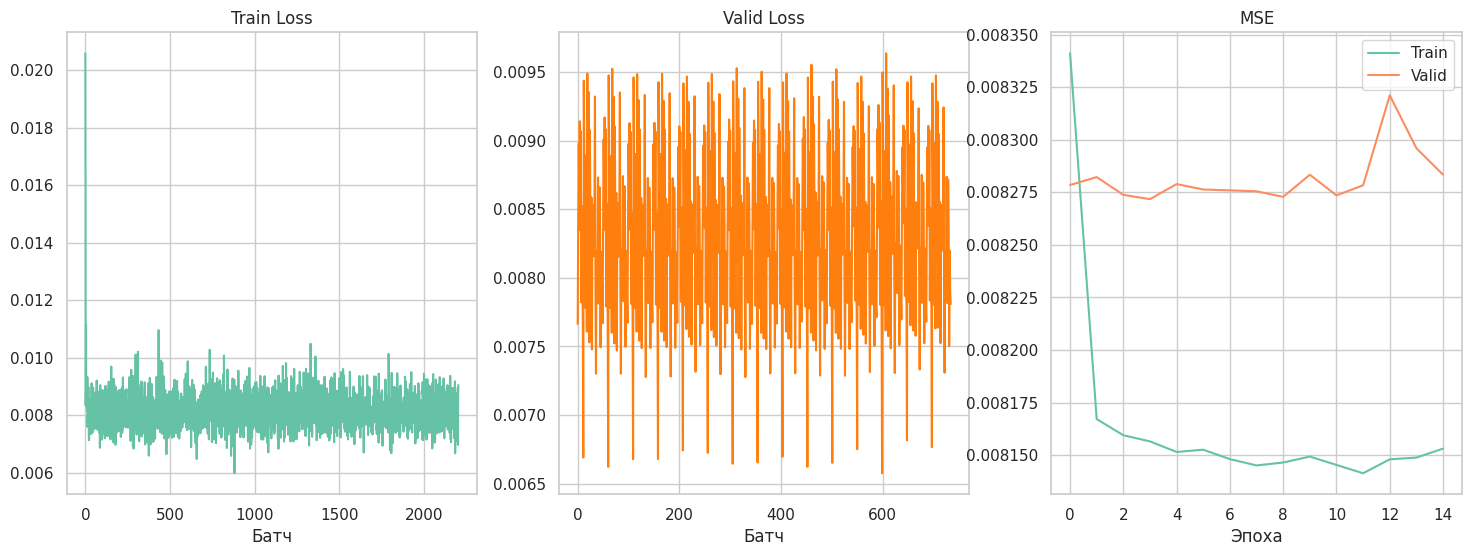

Эпоха: 15 | Время обучения эпохи: 0m 43s


In [22]:
model_emb_size_64 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=64, rnn_num_units=256, output_dim=1).to(device)
criterion = nn.MSELoss()  # У нас задача регрессии, будем использовать MSELoss
optimizer = torch.optim.Adam(model_emb_size_64.parameters(), lr=0.005)
training_loop(model_emb_size_64, optimizer, criterion)
del model_emb_size_64

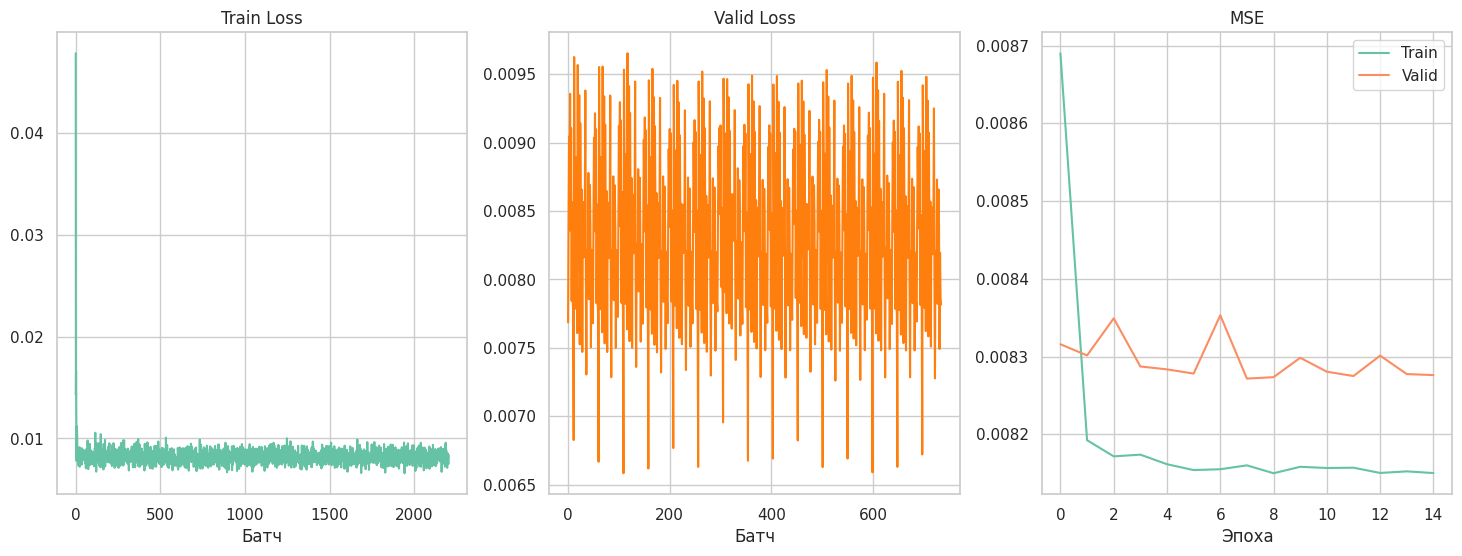

Эпоха: 15 | Время обучения эпохи: 0m 43s


In [23]:
model_num_units_128 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=128, rnn_num_units=128, output_dim=1).to(device)
criterion = nn.MSELoss()  # У нас задача регрессии, будем использовать MSELoss
optimizer = torch.optim.Adam(model_num_units_128.parameters(), lr=0.005)
training_loop(model_num_units_128, optimizer, criterion)
del model_num_units_128

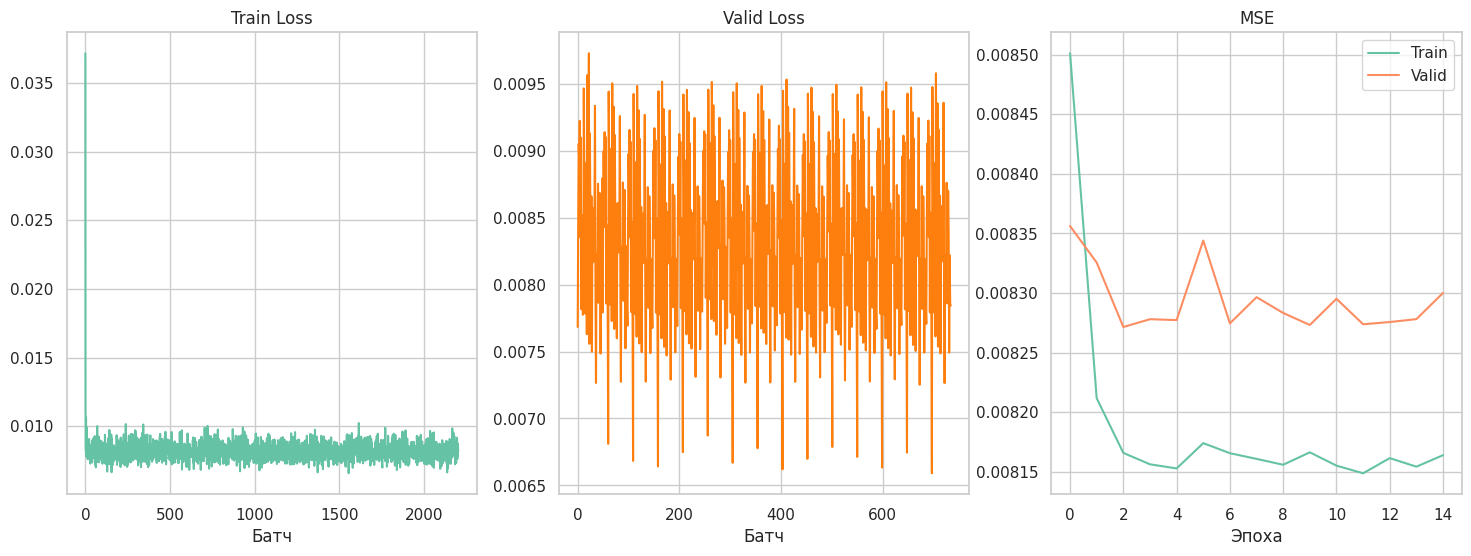

Эпоха: 15 | Время обучения эпохи: 0m 55s


In [25]:
model_emb_size_256 = SimpleRNNRegressor(num_tokens=num_tokens, emb_size=256, rnn_num_units=256, output_dim=1).to(device)
criterion = nn.MSELoss()  # У нас задача регрессии, будем использовать MSELoss
optimizer = torch.optim.Adam(model_emb_size_256.parameters(), lr=0.005)
training_loop(model_emb_size_256, optimizer, criterion)
del model_emb_size_256

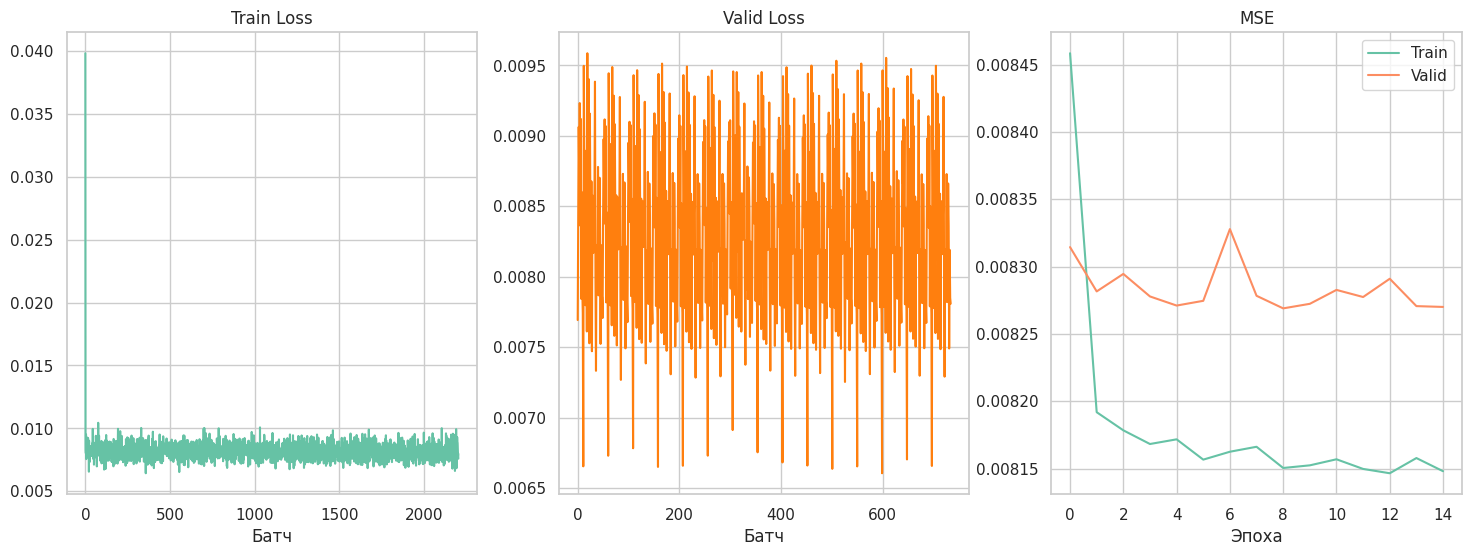

Эпоха: 15 | Время обучения эпохи: 0m 47s


In [27]:
criterion = nn.MSELoss()  # У нас задача регрессии, будем использовать MSELoss
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=0.005)
training_loop(model_baseline, optimizer, criterion)  # бейзлайн

По полученным графикам не получилось с уверенностью установить, как варьирование параметров влияет на качество модели, т.к. во всех случаях алгоритм сошелся примерно к одному и тому же результату.

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [60]:
data_batch, labels_batch = next(iter(valid_loader))
with torch.no_grad():
    preds = model_baseline(data_batch.to(device))

indices = torch.randint(low=0, high=len(data_batch), size=(5,))  # для 5 случайных примеров из тест. батча
# descriptions, true_targets = [], []  # хотел задействовать во 2й задаче, но пришлось разделить ноутбук
for idx in indices:
    print("-" * 20)
    txt = " ".join([token for token in vocab.lookup_tokens(data_batch[idx].tolist()) if token not in ["<unk>", "<pad>"]])
    # descriptions.append(txt)
    print(f"Text:\n{txt}")
    true_target = scaler.inverse_transform(np.array([[labels_batch[idx].item()]])).item()
    # true_targets.append(true_target)
    print(f"True target: {round(true_target, 2)}")
    print(f"Pred target: {round(scaler.inverse_transform(np.array([[preds[idx].item()]])).item(), 2)}")

global_mse = 0
model_baseline.eval()
with torch.no_grad():
    for batch_id, (texts, labels) in enumerate(valid_loader):
        texts, labels = texts.to(device), labels[:,0].to(device)
        predictions = model_baseline(texts).squeeze(1)
        predictions = torch.Tensor(scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1))[:,0])
        labels = torch.Tensor(scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1))[:,0])
        metric = mse(predictions, labels)
        global_mse = ((global_mse * batch_id) + metric.item()) / (batch_id + 1)
print("-" * 20)
print(f'MSE на всем тесте: {round(global_mse, 2)}') 

--------------------
Text:
Reservations Agents Wanted   Glasgow Want join multi national team We looking confident experienced Reservations Agent deal national international reservations   Find price book reservations clients   Advise clients regarding resorts destinations   Make arrangements clients travel programs   Make necessary amendments refunds changes required   General administrative duties Skills Specifications   Ideal candidate able work pressure   Have excellent communication skills   Well travelled consultants excellent track record busy sales environment ideally travel industry   Ability work pressure   Excellent organisational skills   Strong team player   Excellent geographical knowledge passion travel Do feel skills role If call Manchester office AA Appointments reply email contact
True target: 14500.0
Pred target: 33908.97
--------------------
Text:
Our client leading Global financial services firm exciting opportunity Senior Recruitment Manager lead recruitment team 

Какое-то обучение прошло, судя по графикам метрики и лосса, но к сожалению, ошибка все равно довольно высокая (корень из mse порядка 17 000). Вероятно, нужно усложнять архитектуру нейросети

**Вывод:**  
В рамках задачи удалось познакомитсья с NLP и решить задачу регрессии: обучить модель (рекуррентную нейросеть), предсказывающую зарплату по описанию вакансии. По полученным графикам не получилось с уверенностью установить, как варьирование параметров влияет на качество модели, т.к. во всех случаях алгоритм сошелся примерно к одному и тому же результату.  
Ключевой вывод, который можно сделать: модели в NLP как правило очень тяжелые и обучаются крайне долго. Распараллеливание помогло кратно ускорить обучение, но догадываюсь, что в реальной практике необходимо обучаться на гигантских датасетах, а значит, все равно обучение будет проходить долго. Удивительно, что такая задача интуитивно кажется человеку очень легкой (как и многие другие задачи машинного обучения, яркий пример - классификация изображений), но компьютеру требуется много ресурсов. 

---
### Задача 2. Использование большой языковой модели


Последовал рекомендации и прикрепил отдельным файлом